# mount drive and configure envs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/GL-GenAI/Week13-AdvancedGenAI/langgraphTutorials')
os.listdir()

['.env', 'langGraphAgent.ipynb', 'RAG_LangGraph.ipynb', 'my_chroma_db']

In [3]:
# %%writefile .env
# OPENAI_API_KEY=""
# LANGSMITH_API_KEY=""
# LANGSMITH_TRACING=true
# AGENT_API_KEY=""


In [4]:
pip install -q python-dotenv

In [5]:
import openai
from dotenv import load_dotenv

In [6]:
# Set environment variable to avoid tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Force reload of environment variables
load_dotenv(override=True)

True

In [7]:
# Set the OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
AGENT_API_KEY = os.getenv('AGENT_API_KEY')

# print(openai.api_key)   # only for testing
# print(LANGSMITH_API_KEY)
# print(LANGSMITH_TRACING)
# print(AGENT_API_KEY)

In [8]:
!nvidia-smi

Sat Mar  8 05:50:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# References:

- https://www.youtube.com/watch?v=uAEbMpzI3Eg

# Start Coding

In [9]:
!pip install -q langchain langchain-core langchain_community langgraph langchain-huggingface transformers torch

## Data Loaders
- https://python.langchain.com/docs/integrations/document_loaders/

In [10]:
!pip install -q unstructured

from langchain_community.document_loaders import UnstructuredURLLoader

urls = ['https://langchain-ai.github.io/langgraph/tutorials/introduction/']
loader = UnstructuredURLLoader(urls=urls)
docs = loader.load()

## chunking
- using chunk_size of 1000
- using overlap of 200

- I noticed that you are using HuggingFaceEmbeddings, which I believe defaults to: all-MiniLM-L6-v2
-  since all-MiniLM-L6-v2 has embedding dimensions of 384, would not doing chunking with 1000 cause a problem ?  A chunk size of 1000 tokens would exceed the maximum input size for most HuggingFace embedding models, potentially causing errors or truncation of input ?

In [11]:

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # (chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

print("Total number of documents: ",len(all_splits))

Total number of documents:  98


In [12]:
all_splits[7]

Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/'}, page_content="Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, stateful AI applications that go beyond simple query-response interactions.\nGoodbye!\n\nCongratulations! You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a LangSmith Trace for the call above at the provided link.\n\nHowever, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search too

## Embedding
- Embedding models: https://python.langchain.com/v0.1/docs/integrations/text_embedding/

In [13]:
!pip install -q  langchain_huggingface

In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
from langchain_huggingface import HuggingFaceEmbeddings

In [16]:
embedding_model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

In [17]:
import rich

In [18]:
# Initialize SentenceTransformer
embedding_model = SentenceTransformer(embedding_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [20]:
# Initialize HuggingFaceEmbeddings with explicit model name
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,  # Use the string name, not the model instance
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)


In [21]:
vector = embeddings.embed_query("this is a joke")
vector[:5]

[0.029852118343114853,
 -0.05719646066427231,
 -0.0989520475268364,
 -0.01926577277481556,
 0.006274454295635223]

## Vectorstore: Chroma

In [22]:
!pip install -q langchain_chroma

In [23]:
from langchain_chroma import Chroma # import the Chroma class.
from langchain_core.documents import Document

In [24]:
# import shutil
# import os
# # Delete the old vectorstore
# if os.path.exists("./my_chroma_db"):
#     shutil.rmtree("./my_chroma_db")


# from langchain_chroma import Chroma
# from langchain_core.documents import Document

# Recreate the vectorstore with the current embedding model
vectorstore = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings,
    persist_directory="./my_chroma_db"
)

### Loading the vector store

In [25]:
# Loading the Database Later
# This reloads the previously stored embeddings so you don’t have to recompute them.

vectorstore = Chroma(
    persist_directory="./my_chroma_db",
    embedding_function=embeddings
)


## Setting up Hugging Face Pipeline for model

- This code sets up a Falcon-7B language model for text generation using Hugging Face Transformers. It creates a text generation pipeline and wraps it inside HuggingFacePipeline to be used as an LLM.

- device=0, # Runs the model on GPU (CUDA device 0) for acceleration.




In [26]:
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


#model_id = "meta-llama/Meta-Llama-3-8B"
model_id = "tiiuae/falcon-7b"

# text_generation_pipeline = pipeline(
#     "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, max_new_tokens=400, device=0)


text_generation_pipeline = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    max_new_tokens=400,
    device=0, # Runs the model on GPU (CUDA device 0) for acceleration.
    temperature=0.7,  #  (lower values = more deterministic)
    top_k=50,  # Filters out low-probability tokens
)


llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


## cleaning up memory if trying to load again with different parameters

In [57]:
# import torch

# # Empty CUDA cache to free up memory
# torch.cuda.empty_cache()

# # Force garbage collection to remove unused objects
# import gc
# gc.collect()

5711

## Define Prompt

In [27]:
# from langchain_core.prompts import PromptTemplate

# template = """Use the following pieces of context to answer the question at the end.
# If you don't know the answer, just say that you don't know, don't try to make up an answer.
# Use three sentences maximum and keep the answer as concise as possible.
# Always say "thanks for asking!" at the end of the answer.

# {context}

# Question: {question}

# Helpful Answer:"""
# prompt = PromptTemplate.from_template(template)


from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [28]:
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [29]:
# Extract the prompt template from the ChatPromptTemplate object
print(prompt.messages[0].prompt.template)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


## defining the state

- 	TypedDict → Allows defining structured dictionaries with explicit types for each key.
- List → Used to specify that context is a list of Document objects

**State is a dictionary-like structure that explicitly defines:**
- question: The user’s query (string).
- context: A list of retrieved documents (likely from a database or vector store).
- answer: The generated response from the model.

In [30]:

#from typing_extensions import List, TypedDict
from typing import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application state (the nodes)

In [31]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"],  k=1)
    return {"context": retrieved_docs}

In [32]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    #return {"answer": response.content}
    return {"answer": response}

## Define the langGraph

In [33]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

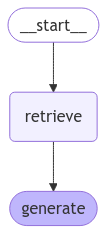

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
response = graph.invoke({"question": "what is langgraph?"})
print(response["answer"])

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: what is langgraph? 
Context: Thank you for your patience. I've found some recent information about LangGraph for you. Let me summarize the key points:

1. LangGraph is part of the LangChain ecosystem, which is a leading platform in AI development.

2. Recent updates and features of LangGraph include:

   a. LangGraph Cloud: This seems to be a cloud-based version of LangGraph, though specific details weren't provided in the search results.

   b. LangGraph Platform: This is a newly introduced concept that combines several offerings:
      - LangGraph Server
      - LangGraph Studio
      - CLI (Command Line Interface)
      - SDK (Software Development Kit)

3. LangGraph Server: This component has received new features to enhance its val